In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

In [6]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=10, restore_best_weights=True
)
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',      # Monitor validation loss
    factor=0.5,              # Reduce the learning rate by a factor of 0.5
    patience=3,              # Number of epochs with no improvement to wait before reducing
    min_lr=1e-6,             # Minimum learning rate
    verbose=1                # Print messages when the learning rate is reduced
)


In [15]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
from tensorflow.keras import layers, regularizers
from scipy.fft import fft

# Positional Encoding Layer
class PositionalEncodingLayer(layers.Layer):
    def __init__(self, d_model, **kwargs):
        super(PositionalEncodingLayer, self).__init__(**kwargs)
        self.d_model = d_model

    def get_angles(self, pos, i):
        angles = pos / tf.pow(10000.0, (2 * (i // 2)) / tf.cast(self.d_model, tf.float32))
        return angles

    def call(self, inputs):
        seq_len = tf.shape(inputs)[1]
        pos = tf.range(seq_len, dtype=tf.float32)[:, tf.newaxis]
        i = tf.range(self.d_model, dtype=tf.float32)[tf.newaxis, :]
        angle_rads = self.get_angles(pos, i)

        # Apply sin to even indices and cos to odd indices
        angle_rads = tf.concat(
            [tf.sin(angle_rads[:, 0::2]), tf.cos(angle_rads[:, 1::2])], axis=-1
        )
        pos_encoding = angle_rads[tf.newaxis, ...]
        return inputs + pos_encoding
# Adjust mask to match reduced sequence length dynamically using a Lambda layer
class MaskAdjustLayer(tf.keras.layers.Layer):
        def call(self, inputs):
          x, mask = inputs
          reduced_seq_len = tf.shape(x)[1]  # Get the reduced sequence length after pooling
          adjusted_mask = mask[:, :reduced_seq_len, :]  # Adjust the mask to match the reduced sequence
          adjusted_mask = tf.expand_dims(adjusted_mask, axis=1)  # Expand dimensions for compatibility
          return adjusted_mask

# Transformer Encoder Layer
def transformer_encoder(inputs, d_model, attention_mask):
    # Multi-Head Attention with Mask
    attention_output = layers.MultiHeadAttention(
        num_heads=8, key_dim=d_model
    )(inputs, inputs, attention_mask=attention_mask)

    attention_output = layers.Dropout(0.3)(attention_output)
    attention_output = layers.Add()([inputs, attention_output])  # Residual connection
    x = layers.LayerNormalization()(attention_output)

    # Feedforward Network
    feedforward_output = layers.Dense(d_model, activation='relu')(x)
    feedforward_output = layers.Dropout(0.3)(feedforward_output)
    feedforward_output = layers.Add()([x, feedforward_output])  # Residual connection
    x = layers.LayerNormalization()(feedforward_output)

    return x

def build_model_with_positional_encoding(input_shape, d_model=64, num_transformer_layers=2):
    inputs = tf.keras.Input(shape=input_shape)

    # Create padding mask
    mask = tf.keras.layers.Lambda(lambda x: tf.cast(tf.not_equal(x, 0), tf.float32))(inputs)

    # Conv1D Stack
    x = layers.Conv1D(32, kernel_size=3, activation='relu', padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    # x = layers.Dropout(0.1)(x)
    x = layers.Conv1D(64, kernel_size=3, activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv1D(128, kernel_size=3, activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling1D(pool_size=2)(x)  # Reduces sequence length

    x = layers.Conv1D(d_model, kernel_size=3, activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling1D(pool_size=2)(x)  # Further reduces sequence length

    # Positional Encoding
    x = PositionalEncodingLayer(d_model)(x)

    # Adjust the mask to match the reduced sequence length
    adjusted_mask = MaskAdjustLayer()([x, mask])

    # Transformer Encoder Stack
    for _ in range(num_transformer_layers):
        x = transformer_encoder(x, d_model, adjusted_mask)

    # Global Pooling and Dense Layers
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.02))(x)
    # x = layers.Dropout(0.2)(x)
    x = layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.02))(x)
    # x = layers.Dropout(0.2)(x)

    # Output Layer
    outputs = layers.Dense(1, activation='sigmoid')(x)

    model = tf.keras.Model(inputs, outputs)
    return model

#,clipnorm=1.0


# Load and preprocess data (same as before)
normal_df = pd.read_csv('/content/drive/MyDrive/normal.csv', header=None)
abnormal_df = pd.read_csv('/content/drive/MyDrive/abnormal.csv', header=None)

# Merge and shuffle datasets
data = pd.concat([normal_df, abnormal_df], ignore_index=True).sample(frac=1).reset_index(drop=True)

# Separate features and labels
X = data.iloc[:, :-1].values  # All columns except the last
y = data.iloc[:, -1].values   # Last column as labels

# Train-test split (80-20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Train-validation split (80-20)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

# Apply Fourier Transform (FFT) to ECG signals
def apply_fft(signal):
    N = len(signal)
    fft_values = fft(signal)
    magnitude_spectrum = np.abs(fft_values)[:N // 2]
    return magnitude_spectrum

# Preprocess ECG signals by applying FFT
X_train_processed = np.array([apply_fft(x) for x in X_train])
X_val_processed = np.array([apply_fft(x) for x in X_val])
X_test_processed = np.array([apply_fft(x) for x in X_test])





from imblearn.over_sampling import RandomOverSampler
import numpy as np

#Assuming X_train and y_train are your features and labels
print(f"Original class distribution: {np.bincount(y_train.astype(int))}")

#Initialize the oversampler
ros = RandomOverSampler(random_state=42)

#Resample the dataset
X_train_processed, y_train = ros.fit_resample(X_train_processed, y_train)

print(f"Resamples class distribution: {np.bincount(y_train.astype(int))}")


# Build and compile the model
input_shape = (X_train_processed.shape[1], 1)  # Adjust based on the shape of your data
model = build_model_with_positional_encoding(input_shape)  # Adjust max_len based on your data
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001 , clipnorm=1.0),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(
    X_train_processed[..., np.newaxis], y_train,
    validation_data=(X_val_processed[..., np.newaxis], y_val),
    epochs=45,
    batch_size=64,
    callbacks = [reduce_lr]
)

# Evaluate the model
y_pred = (model.predict(X_test_processed[..., np.newaxis]) > 0.5).astype(int)
conf_matrix = confusion_matrix(y_test, y_pred)

# Print results
# print("Confusion Matrix:")
# print(conf_matrix)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Original class distribution: [2589 6723]
Resamples class distribution: [6723 6723]
Epoch 1/45
211/211 ━━━━━━━━━━━━━━━━━━━━ 41s 94ms/step - accuracy: 0.7751 - loss: 1.7585 - val_accuracy: 0.4410 - val_loss: 1.4999 - learning_rate: 0.0010
Epoch 2/45
211/211 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.8966 - loss: 0.4148 - val_accuracy: 0.8785 - val_loss: 0.3944 - learning_rate: 0.0010
Epoch 3/45
211/211 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9282 - loss: 0.2571 - val_accuracy: 0.9223 - val_loss: 0.2436 - learning_rate: 0.0010
Epoch 4/45
211/211 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9383 - loss: 0.2132 - val_accuracy: 0.9382 - val_loss: 0.2270 - learning_rate: 0.0010
Epoch 5/45
211/211 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9620 - loss: 0.1433 - val_accuracy: 0.9515 - val_loss: 0.1712 - learning_rate: 0.0010
Epoch 6/45
211/211 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9683 - loss: 0.1253 - val_accuracy: 0.9614 - val_loss: 0.1307 - learning_rate: 0.0010
Ep

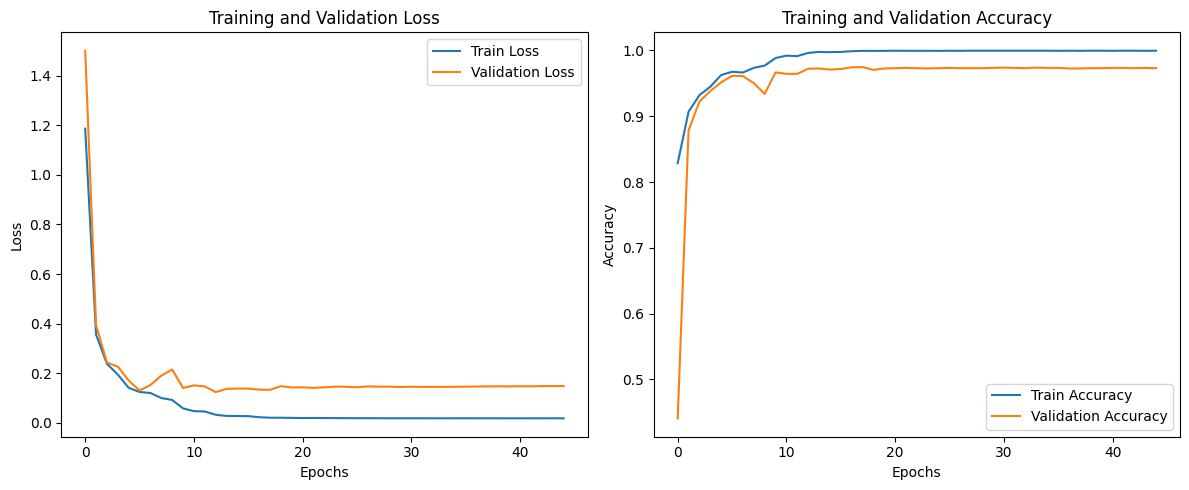

In [17]:
plot_training_history(history)

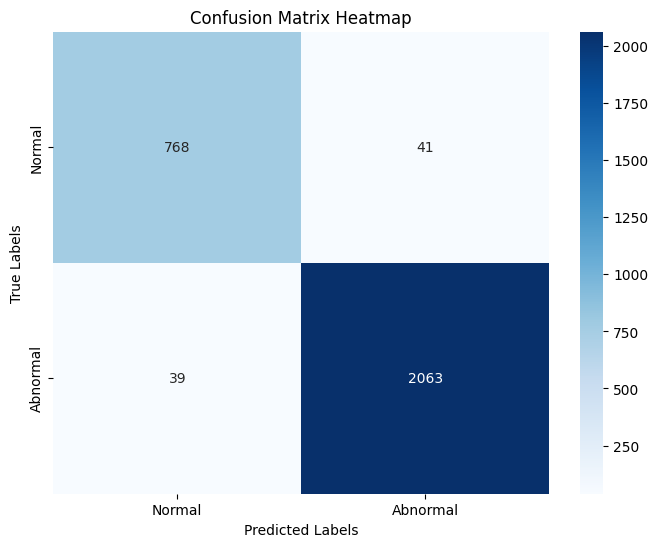

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot the confusion matrix as a heatmap
def plot_confusion_matrix(conf_matrix, labels):
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.title("Confusion Matrix Heatmap")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.show()

# Plot training and validation loss and accuracy over epochs
def plot_training_history(history):
    # Plot loss
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title("Training and Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title("Training and Validation Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.tight_layout()
    plt.show()

# After training the model
labels = ['Normal', 'Abnormal']  # Define labels for the classes
plot_confusion_matrix(conf_matrix, labels)  # Plot the confusion matrix
  # Plot training and validation metrics


In [7]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras import layers, regularizers
from tensorflow.keras.utils import to_categorical
from scipy.fft import fft

# Load the CSV files for training and testing
train_df = pd.read_csv('/content/drive/MyDrive/mitbih_train.csv', header=None)  # No header row
test_df = pd.read_csv('/content/drive/MyDrive/mitbih_test.csv', header=None)  # No header row

# The last column is the label (class), and all other columns are features
X_train = train_df.iloc[:, :-1].values
y_train = train_df.iloc[:, -1].values
X_test = test_df.iloc[:, :-1].values
y_test = test_df.iloc[:, -1].values

# Split the training data into 80% for training and 20% for validation
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

# Apply Fourier Transform (FFT) to ECG signals
def apply_fft(signal):
    N = len(signal)
    fft_values = fft(signal)
    magnitude_spectrum = np.abs(fft_values)[:N // 2]
    return magnitude_spectrum

# Preprocess ECG signals by applying FFT
X_train_processed = np.array([apply_fft(x) for x in X_train])
X_val_processed = np.array([apply_fft(x) for x in X_val])
X_test_processed = np.array([apply_fft(x) for x in X_test])



# Convert labels to categorical (one-hot encoding) for multi-class classification
y_train = to_categorical(y_train, num_classes=5)  # 5 classes
y_val = to_categorical(y_val, num_classes=5)  # 5 classes
y_test = to_categorical(y_test, num_classes=5)  # 5 classes






from imblearn.over_sampling import RandomOverSampler
import numpy as np
from tensorflow.keras.utils import to_categorical

# Convert one-hot encoded labels back to integer form
y_train_int = np.argmax(y_train, axis=1)

# Check the original class distribution
print(f"Original class distribution: {np.bincount(y_train_int)}")

# Initialize the oversampler
ros = RandomOverSampler(random_state=42)

# Resample the dataset
X_train_processed, y_train_resampled = ros.fit_resample(X_train_processed, y_train_int)

# Check the class distribution after oversampling
print(f"Resampled class distribution: {np.bincount(y_train_resampled)}")

# Convert the resampled labels back to one-hot encoding
y_train = to_categorical(y_train_resampled, num_classes=5)






import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
from tensorflow.keras import layers, regularizers
from scipy.fft import fft

# Positional Encoding Layer
class PositionalEncodingLayer(layers.Layer):
    def __init__(self, d_model, **kwargs):
        super(PositionalEncodingLayer, self).__init__(**kwargs)
        self.d_model = d_model

    def get_angles(self, pos, i):
        angles = pos / tf.pow(10000.0, (2 * (i // 2)) / tf.cast(self.d_model, tf.float32))
        return angles

    def call(self, inputs):
        seq_len = tf.shape(inputs)[1]
        pos = tf.range(seq_len, dtype=tf.float32)[:, tf.newaxis]
        i = tf.range(self.d_model, dtype=tf.float32)[tf.newaxis, :]
        angle_rads = self.get_angles(pos, i)

        # Apply sin to even indices and cos to odd indices
        angle_rads = tf.concat(
            [tf.sin(angle_rads[:, 0::2]), tf.cos(angle_rads[:, 1::2])], axis=-1
        )
        pos_encoding = angle_rads[tf.newaxis, ...]
        return inputs + pos_encoding
# Adjust mask to match reduced sequence length dynamically using a Lambda layer
class MaskAdjustLayer(tf.keras.layers.Layer):
        def call(self, inputs):
          x, mask = inputs
          reduced_seq_len = tf.shape(x)[1]  # Get the reduced sequence length after pooling
          adjusted_mask = mask[:, :reduced_seq_len, :]  # Adjust the mask to match the reduced sequence
          adjusted_mask = tf.expand_dims(adjusted_mask, axis=1)  # Expand dimensions for compatibility
          return adjusted_mask

# Transformer Encoder Layer
def transformer_encoder(inputs, d_model, attention_mask):
    # Multi-Head Attention with Mask
    attention_output = layers.MultiHeadAttention(
        num_heads=8, key_dim=d_model
    )(inputs, inputs, attention_mask=attention_mask)

    attention_output = layers.Dropout(0.1)(attention_output)
    attention_output = layers.Add()([inputs, attention_output])  # Residual connection
    x = layers.LayerNormalization()(attention_output)

    # Feedforward Network
    feedforward_output = layers.Dense(d_model, activation='relu')(x)
    feedforward_output = layers.Dropout(0.1)(feedforward_output)
    feedforward_output = layers.Add()([x, feedforward_output])  # Residual connection
    x = layers.LayerNormalization()(feedforward_output)

    return x

def build_model_with_positional_encoding(input_shape, d_model=64, num_transformer_layers=4):
    inputs = tf.keras.Input(shape=input_shape)

    # Create padding mask
    mask = tf.keras.layers.Lambda(lambda x: tf.cast(tf.not_equal(x, 0), tf.float32))(inputs)

    # Conv1D Stack
    x = layers.Conv1D(128, kernel_size=3, activation='relu', padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Conv1D(128, kernel_size=3, activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling1D(pool_size=2)(x)  # Reduces sequence length

    x = layers.Conv1D(d_model, kernel_size=3, activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling1D(pool_size=2)(x)  # Further reduces sequence length

    # Positional Encoding
    x = PositionalEncodingLayer(d_model)(x)

    # Adjust the mask to match the reduced sequence length
    adjusted_mask = MaskAdjustLayer()([x, mask])

    # Transformer Encoder Stack
    for _ in range(num_transformer_layers):
        x = transformer_encoder(x, d_model, adjusted_mask)

    # Global Pooling and Dense Layers
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
    x = layers.Dropout(0.4)(x)
    x = layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
    x = layers.Dropout(0.4)(x)

    # Output Layer
     # Output Layer (5 classes, so use softmax)
    outputs = layers.Dense(5, activation='softmax')(x)  # Softmax for multi-class classification

    model = tf.keras.Model(inputs, outputs)
    return model



# Build and compile the model
input_shape = (X_train_processed.shape[1], 1)  # Adjust based on the shape of your data
model = build_model_with_positional_encoding(input_shape)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001 , clipnorm=1.0),
              loss='categorical_crossentropy',  # Use categorical crossentropy for multi-class
              metrics=['accuracy'])

# Train the model
history = model.fit(
    X_train_processed[..., np.newaxis], y_train,
    validation_data=(X_val_processed[..., np.newaxis], y_val),
    epochs=30,
    batch_size=64,
    callbacks = [reduce_lr]
)

# Evaluate the model
y_pred = np.argmax(model.predict(X_test_processed[..., np.newaxis]), axis=-1)  # Get the class with max probability
y_test_labels = np.argmax(y_test, axis=-1)  # Convert one-hot encoded labels back to class indices

conf_matrix = confusion_matrix(y_test_labels, y_pred)

# Print results
print("Confusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(classification_report(y_test_labels, y_pred))


Original class distribution: [57977  1778  4630   513  5145]
Resampled class distribution: [57977 57977 57977 57977 57977]
Epoch 1/30
4530/4530 ━━━━━━━━━━━━━━━━━━━━ 109s 16ms/step - accuracy: 0.8228 - loss: 0.7881 - val_accuracy: 0.8743 - val_loss: 0.4267 - learning_rate: 0.0010
Epoch 2/30
4530/4530 ━━━━━━━━━━━━━━━━━━━━ 101s 12ms/step - accuracy: 0.9322 - loss: 0.2547 - val_accuracy: 0.9143 - val_loss: 0.2696 - learning_rate: 0.0010
Epoch 3/30
4530/4530 ━━━━━━━━━━━━━━━━━━━━ 53s 12ms/step - accuracy: 0.9470 - loss: 0.2018 - val_accuracy: 0.8915 - val_loss: 0.3143 - learning_rate: 0.0010
Epoch 4/30
4530/4530 ━━━━━━━━━━━━━━━━━━━━ 52s 12ms/step - accuracy: 0.9536 - loss: 0.1784 - val_accuracy: 0.9071 - val_loss: 0.3051 - learning_rate: 0.0010
Epoch 5/30
4530/4530 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9607 - loss: 0.1555
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
4530/4530 ━━━━━━━━━━━━━━━━━━━━ 82s 12ms/step - accuracy: 0.9607 - loss: 0.1555 - val_a

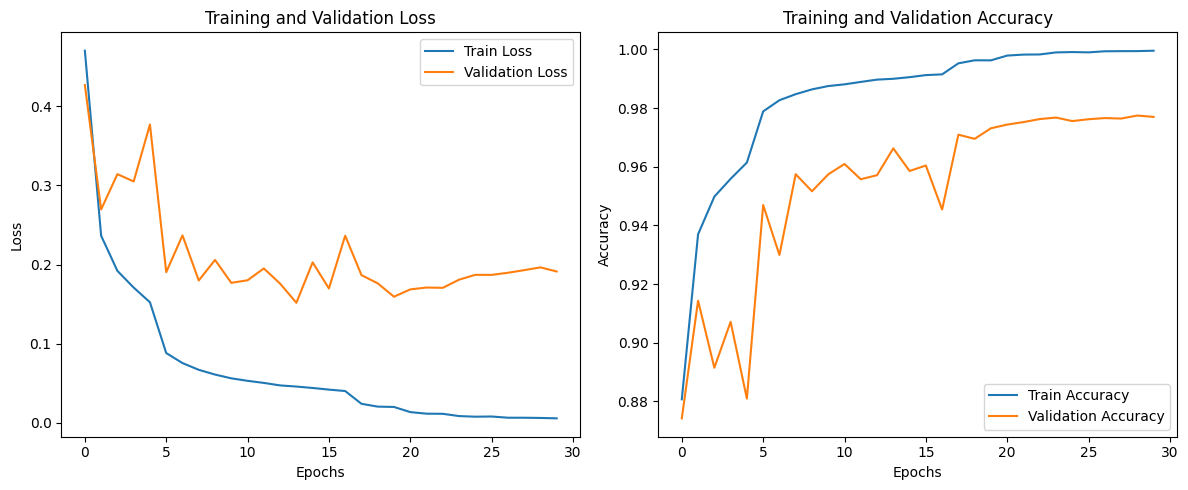

In [9]:
plot_training_history(history)

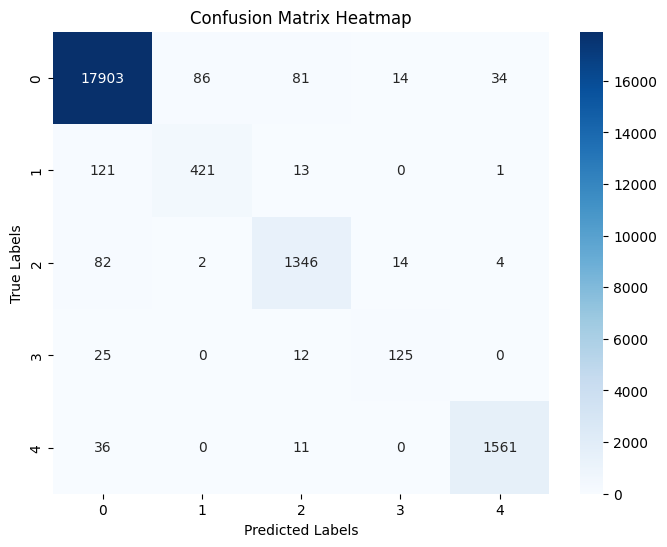

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot the confusion matrix as a heatmap
def plot_confusion_matrix(conf_matrix, labels):
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.title("Confusion Matrix Heatmap")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.show()

# Plot training and validation loss and accuracy over epochs
def plot_training_history(history):
    # Plot loss
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title("Training and Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title("Training and Validation Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.tight_layout()
    plt.show()

# After training the model
labels = ['0', '1','2','3','4']  # Define labels for the classes
plot_confusion_matrix(conf_matrix, labels)